# Download packages

In [ ]:
%pip install pillow scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [23]:
%pip install opencv-python matplotlib

  Using cached opencv_python-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl (54.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 548.3 kB/s eta 0:00:0000:0100:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 154.2 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


# Import libraries

In [ ]:
import os
from zipfile import ZipFile

from PIL import Image
from sklearn.model_selection import train_test_split

import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split

# Download data

In [112]:
zip_path = r"./data/ExtendedYaleB/Ext Yale B Cropped PNG.zip"
output_dir = r"data/ExtendedYaleB"

with ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(output_dir)

## Data analys 

In [113]:
# Путь к загруженным данным
dataset_path = Path("data")  # Укажите путь к вашей папке с датасетом

# Проверяем наличие изображений
if not dataset_path.exists():
    raise FileNotFoundError(f"Датасет не найден в папке: {dataset_path}")

# Получаем список изображений
image_files = list(dataset_path.glob("**/*.png"))  # Меняем расширение в зависимости от формата (jpg, png, bmp)
if not image_files:
    raise FileNotFoundError("Изображения не найдены в указанной папке.")

# Вывод информации о датасете
print(f"Общее количество изображений: {len(image_files)}")
print("Пример структуры данных:")
for img_path in image_files[:5]:
    print(f"Файл: {img_path}, Размер: {os.path.getsize(img_path)} байт")

Общее количество изображений: 2452
Пример структуры данных:
Файл: data/ExtendedYaleB/CroppedYalePNG/yaleB36_P00A-020E+10.png, Размер: 18582 байт
Файл: data/ExtendedYaleB/CroppedYalePNG/yaleB23_P00A-110E+40.png, Размер: 13419 байт
Файл: data/ExtendedYaleB/CroppedYalePNG/yaleB08_P00A-020E+10.png, Размер: 18988 байт
Файл: data/ExtendedYaleB/CroppedYalePNG/yaleB20_P00A-020E-40.png, Размер: 16643 байт
Файл: data/ExtendedYaleB/CroppedYalePNG/yaleB30_P00A-035E+65.png, Размер: 15966 байт


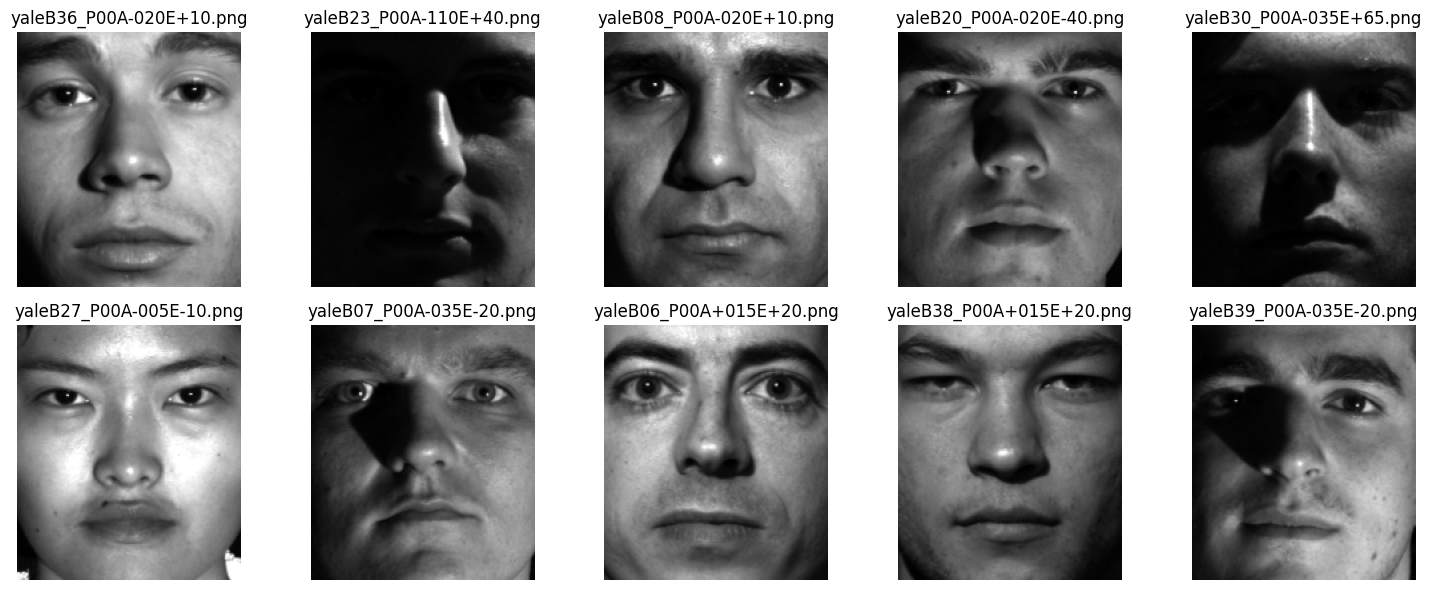

In [114]:
# Отображение нескольких изображений
def show_images(image_paths, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    for i, img_path in enumerate(image_paths[:rows * cols]):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)  # Чтение в градациях серого
        ax = axes[i // cols, i % cols]
        ax.imshow(img, cmap="gray")
        ax.set_title(f"{img_path.name}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_images(image_files)

In [115]:
# Функция для анализа свойств изображений
def analyze_images(image_paths):
    heights, widths = [], []
    for img_path in image_paths:
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        heights.append(img.shape[0])
        widths.append(img.shape[1])
    print(f"Средняя высота: {sum(heights) / len(heights):.2f}")
    print(f"Средняя ширина: {sum(widths) / len(widths):.2f}")
    print(f"Минимальная высота: {min(heights)}, Минимальная ширина: {min(widths)}")
    print(f"Максимальная высота: {max(heights)}, Максимальная ширина: {max(widths)}")

# Анализ изображений
analyze_images(image_files)

Средняя высота: 195.29
Средняя ширина: 173.39
Минимальная высота: 192, Минимальная ширина: 168
Максимальная высота: 480, Максимальная ширина: 640


## Preprocessing data

In [116]:
# Указываем пути к исходным данным и папке для обработанных изображений
dataset_dir = Path("data/ExtendedYaleB")
resized_dir = Path("data/ExtendedYaleB/ResizedYaleB")

# Создание папки для обработанных изображений
resized_dir.mkdir(parents=True, exist_ok=True)

# Размер нового изображения
target_size = (48, 42)

# Список всех изображений
image_files = list(dataset_dir.glob("**/*.png"))  # Поиск всех PNG-файлов
if not image_files:
    raise FileNotFoundError("Изображения не найдены в указанной папке.")

# Изменение размера изображений
for img_path in image_files:
    with Image.open(img_path) as img:
        img_resized = img.resize(target_size)
        # Сохранение в папку ResizedYaleB с тем же именем файла
        img_resized.save(resized_dir / img_path.name)

print("Изображения предобработаны и сохранены в папке:", resized_dir)


Изображения предобработаны и сохранены в папке: data/ExtendedYaleB/ResizedYaleB


## Data grouping

In [117]:
# Указываем путь к данным
dataset_path = Path("data")  # Замените на ваш путь к данным
output_path = Path("data/ExtendedYaleB/GroupedDataBySubject")
output_path.mkdir(exist_ok=True)

# Проверяем, что данные существуют
if not dataset_path.exists():
    raise FileNotFoundError(f"Данные не найдены в папке: {dataset_path}")

# Функция для разбора имени файла
def parse_filename(filename):
    """
    Разбирает имя файла в формате yaleBxx_P00A(+/-)aaaE(+/-)ee.png.
    Возвращает словарь с информацией о субъекте.
    """
    parts = filename.stem.split("_")
    subject_id = parts[0][5:]  # Получаем xx из yaleBxx
    return {"subject": subject_id}

# Группировка данных
grouped_data = defaultdict(list)

# Получаем список изображений
image_files = list(dataset_path.glob("**/*.png"))  # Меняем расширение в зависимости от формата (jpg, png, bmp)
if not image_files:
    raise FileNotFoundError("Изображения не найдены в указанной папке.")

# Группируем изображения по ID субъекта
for img_file in image_files:
    info = parse_filename(img_file)
    key = f"Subject_{info['subject']}"
    grouped_data[key].append(img_file)

# Создаем папки и перемещаем файлы в соответствии с группировкой
for group, files in grouped_data.items():
    group_dir = output_path / group
    group_dir.mkdir(parents=True, exist_ok=True)
    for file in files:
        file.rename(group_dir / file.name)

print(f"Файлы успешно сгруппированы по субъектам и сохранены в папке {output_path}")


Файлы успешно сгруппированы по субъектам и сохранены в папке data/ExtendedYaleB/GroupedDataBySubject


## Split data

In [118]:
# Указываем путь к данным
dataset_path = Path("data/ExtendedYaleB/GroupedDataBySubject")  # Путь к папке с изображениями, сгруппированными по субъектам
output_path = Path("data/ExtendedYaleB/SplitData")  # Папка для хранения разделенных данных
output_path.mkdir(exist_ok=True)

# Создаем папки для каждого эксперимента
experiments_dir = output_path / "Experiments"
experiments_dir.mkdir(exist_ok=True)

# Считываем данные по субъектам
subject_images = defaultdict(list)
for subject_dir in dataset_path.iterdir():
    if subject_dir.is_dir():
        subject_id = subject_dir.name
        subject_images[subject_id] = list(subject_dir.glob("*.png"))

# Проверка на наличие данных
if not subject_images:
    raise ValueError("Данные для субъектов не найдены!")

# Функция для разбиения данных на train/test
def split_data(subject_images, experiment_id, train_ratio=0.8):
    """
    Делит данные для каждого субъекта на тренировочный и тестовый наборы.
    Результаты сохраняются в отдельные папки для каждого эксперимента.
    """
    experiment_dir = experiments_dir / f"Experiment_{experiment_id}"
    train_dir = experiment_dir / "train"
    test_dir = experiment_dir / "test"
    train_dir.mkdir(parents=True, exist_ok=True)
    test_dir.mkdir(parents=True, exist_ok=True)

    for subject, images in subject_images.items():
        # Разделение на train и test
        train_images, test_images = train_test_split(
            images, test_size=np.round(1-train_ratio, 1), random_state=experiment_id
        )
        # Сохранение в соответствующие папки
        subject_train_dir = train_dir / subject
        subject_test_dir = test_dir / subject
        subject_train_dir.mkdir(parents=True, exist_ok=True)
        subject_test_dir.mkdir(parents=True, exist_ok=True)

        for img in train_images:
            shutil.copy(img, subject_train_dir / img.name)
        for img in test_images:
            shutil.copy(img, subject_test_dir / img.name)

    print(f"Эксперимент {experiment_id}: данные успешно разделены.")

# Проведение 20 экспериментов с разными random_state
for experiment_id in range(1, 21):
    split_data(subject_images, experiment_id)

Эксперимент 1: данные успешно разделены.
Эксперимент 2: данные успешно разделены.
Эксперимент 3: данные успешно разделены.
Эксперимент 4: данные успешно разделены.
Эксперимент 5: данные успешно разделены.
Эксперимент 6: данные успешно разделены.
Эксперимент 7: данные успешно разделены.
Эксперимент 8: данные успешно разделены.
Эксперимент 9: данные успешно разделены.
Эксперимент 10: данные успешно разделены.
Эксперимент 11: данные успешно разделены.
Эксперимент 12: данные успешно разделены.
Эксперимент 13: данные успешно разделены.
Эксперимент 14: данные успешно разделены.
Эксперимент 15: данные успешно разделены.
Эксперимент 16: данные успешно разделены.
Эксперимент 17: данные успешно разделены.
Эксперимент 18: данные успешно разделены.
Эксперимент 19: данные успешно разделены.
Эксперимент 20: данные успешно разделены.
